# Stanojevic et al., 2018

In [1]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
import mpld3
from scipy.interpolate import interp1d
import scipy.optimize as sco
from tabulate import tabulate
from decimal import Decimal

## Parameters and Initial Conditions

In [178]:
print(carrollControlACTH[0,1], carrollControlCortisol[0,1])

4.934435428117939e-12 5.2511256414500915e-08


In [179]:
# initial conditions, based on the data set to be matched
#    need to look up reasonable estimates for all except CORT, ACTH
#    EtOH and AcALD, though
#
# For now, EtOH and AcALD are set to 0, as we are not currently
#    interested in the effects of alcohol 

y0 = [4.934435428117939e-12, 1.5e-9, 3.4e-4, 5.2511256414500915e-8, 1e-12, 1.5e-10, 1.5e-11, 1.5e-10, 1.5e-11, 1.0e-10, 4.0e-8, 1.5e-15, 1.5e-15, 4.0e-8, 4.0e-8, 4.0e-8, 4.0e-8, 0, 0]


In [3]:
# parameters to be optimized

d1 = 0.3025        # d1 governs mean daily CRH concentration
d2 = 1.            # d2 governs circadian amplitude in CRH concentration
# we aren't given reasonable bounds on either d1 or d2 in the paper, so I'll probably just do +- 10%
k1 = 3.31e-4
k2 = 8.78e-8
k3 = 1.46e-10
k4 = 2.2e4
k5 = 240
k6 = 240
k7 = 7.61e18
k8 = 1.9e10
k9 = 15.47
k10 = 7.7
k11 = 0.037
k12 = 0.023
k13 = 0.25
k14 = 0.25
k15 = 0.24
k16 = 1e-4
k17 = 3.02e12
k18 = 1.69e13
k19 = 7.2e10
k20 = 6e8
k21 = 1.28e3
k22 = 0.81
k23 = 2.4e3
k24 = 2.4e4
k25 = 0.11
k26 = 0.098
k27 = 0.0013
k28 = 0.026
k29 = 12
k30 = 1e-3
k31 = 2.5e-7
k32 = 0.005
k33 = 0.1

x0 = [d1, d2, k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16, k17, k18, k19, k20, k21, k22, k23, k24, k25, k26, k27, k28, k29, k30, k31, k32, k33]


In [148]:
# compute bounds based on +- 5%
bound = k30
print(bound - bound*.05)
print(bound + bound*.05)

0.00095
0.00105


In [154]:
# try just 2 params
bounds = ([0.287375, 0.317625], [0.95, 1.05])

In [182]:
# add a 3rd
bounds = ([0.287375, 0.317625], [0.95, 1.05], [8.341e-08, 9.219000000000001e-08])

In [149]:
# try optimizing only a few parameters
# 2, 4, 5, 7, 12, 17, 18, 19, 20, 21, 26, 27, 30
bounds = ([0.287375, 0.317625], [0.95, 1.05], [8.341e-08, 9.219000000000001e-08], [20900.0, 23100.0], [228.0, 252.0], [7.2295e+18, 7.9905e+18], [0.02185, 0.024149999999999998], [2869000000000.0, 3171000000000.0], [16055000000000.0, 17745000000000.0], [68400000000.0, 75600000000.0], [570000000.0, 630000000.0], [1216.0, 1344.0], [0.0931, 0.1029], [0.001235, 0.001365], [0.00095, 0.00105])

In [132]:
# bounds for each parameter to be fed into parameter optimization algorithm
# unfortunately, the authors did not give any bounds on parameters,
# so to start I will be using +- 10% on the published parameter values
bounds = ([0.287375, 0.317625], [0.95, 1.05], [0.00031445, 0.00034755], [8.341e-08, 9.219000000000001e-08], [1.3870000000000002e-10, 1.533e-10], [20900.0, 23100.0], [228., 252.], [228., 252.], [7.2295e+18, 7.9905e+18], [18050000000.0, 19950000000.0], [14.6965, 16.2435], [7.315, 8.085], [0.03515, 0.038849999999999996], [0.02185, 0.024149999999999998], [0.2375, 0.2625], [0.2375, 0.2625], [0.22799999999999998, 0.252], [9.5e-05, 0.000105], [2869000000000.0, 3171000000000.0], [16055000000000.0, 17745000000000.0], [68400000000.0, 75600000000.0], [570000000.0, 630000000.0], [1216.0, 1344.0], [0.7695000000000001, 0.8505], [2280.0, 2520.0], [22800.0, 25200.0], [0.1045, 0.1155], [0.0931, 0.1029], [0.001235, 0.001365], [0.0247, 0.027299999999999998], [11.4, 12.6], [0.00095, 0.00105], [2.375e-07, 2.625e-07], [0.00475, 0.00525], [0.095, 0.10500000000000001])


In [200]:
# length of time over which we wish to integrate
timeLength = (0,11521)

t_start = -0.01
t_end = 11521
t_step = 0.01

In [34]:
# length of time over which we wish to integrate for matching Dr Nelson's data
timeLength = (-0.01,140.01)

# time interval and step definition, for using scipy.integrate.ode
t_start = -0.01
t_end = 140.01
t_step = 0.01

# For conversion of data to moles:

## ACTH = 2933.444 g/mol
## Cortisol = 362.46 g/mol

# Then we need to make the following conversions:
## x pg/mL ACTH = x/2933.444e9 mol/L ACTH = x/2.933444e12 mol/L ACTH
## x micrograms/dL Cortisol = x/362.46e5 mol/L Cortisol = x/3.6246e7 mol/L Cortisol

## Put extracted data from control patient F (Bangsgaard & Ottesen, 2017) into arrays and smooth over neighboring 5 points

In [6]:
# generate arrays for the cortisol and ACTH data from control patient F in the Bangsgaard & Ottesen paper
patientFcortisol = np.genfromtxt("Bangsgaard-Ottesen-2017-patient-f-cortisol-data.txt")
patientFacth = np.genfromtxt("Bangsgaard-Ottesen-2017-patient-f-ACTH-data.txt")


In [7]:
# this function computes the moving average over the neighboring 5 points
def smoothing(a, n=5) :
    idx = int((n-1)/2)
    ret = np.cumsum(a, dtype=float)
    ret[idx+1:-idx] = ret[n:] - ret[:-n]
    ret[idx] = ret[idx+2]
    return ret[idx:-idx] / n

In [8]:
# create arrays for the smoothed data
patientFcortisol_smooth = patientFcortisol
patientFacth_smooth = patientFacth

# run the smoothing function on the raw data
# REMEMBER: need to re-extract the data from the files into the non-smooth arrays to make them non-smooth.
#     I'm still not sure why it's smoothing the original data when I only save the values from the smoothing function
#     into the smooth arrays
patientFcortisol_smooth[2:-2,1] = smoothing(patientFcortisol[:,1])
patientFacth_smooth[2:-2,1] = smoothing(patientFacth[:,1])

In [9]:
patientFcortisol = np.genfromtxt("Bangsgaard-Ottesen-2017-patient-f-cortisol-data.txt")
patientFacth = np.genfromtxt("Bangsgaard-Ottesen-2017-patient-f-ACTH-data.txt")


### Convert Scales

In [10]:
# convert the time scale to minutes so that it agrees with the ODEs

for i in range(len(patientFcortisol_smooth[:,0])):
    patientFcortisol_smooth[i,0] = patientFcortisol[i,0]*60
for i in range(len(patientFacth_smooth[:,0])):
    patientFacth_smooth[i,0] = patientFacth[i,0]*60

In [11]:
for i in range(len(patientFcortisol[:,1])):
    patientFcortisol[i,1] = patientFcortisol[i,1]/3.6246e7
    patientFcortisol_smooth[i,1] = patientFcortisol_smooth[i,1]/3.6246e7
    
for i in range(len(patientFacth[:,1])):
    patientFacth[i,1] = patientFacth[i,1]/2.933444e12
    patientFacth_smooth[i,1] = patientFacth_smooth[i,1]/2.933444e12

### Plot Patient F Data

[Text(0, 0.5, 'ACTH (M/L)'), Text(0.5, 0, 'Time (hours)')]

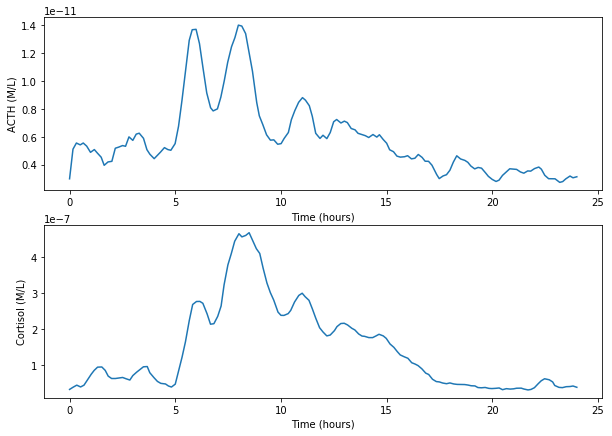

In [12]:
# plot the smoothed data to check it against the figures in the paper
#mpld3.enable_notebook()
%matplotlib inline
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(10,7))
ax2.plot(patientFcortisol[:,0], patientFcortisol_smooth[:,1], '-')
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (M/L)")
ax1.plot(patientFacth[:,0], patientFacth_smooth[:,1], '-')
ax1.set(xlabel="Time (hours)", ylabel="ACTH (M/L)")

## Put Raw Data Into Arrays

In [13]:
yehudaControlCortisol = np.genfromtxt("yehuda-control-cortisol.txt")
yehudaPTSDCortisol = np.genfromtxt("yehuda-PTSD-cortisol.txt")
yehudaDepressedCortisol = np.genfromtxt("yehuda-depressed-cortisol.txt")

In [14]:
# extract the data from text files into 145x2 arrays
carrollControlCortisol = np.genfromtxt("controlGroupCortisolCarroll.txt", dtype = float)
carrollHCDepressedCortisol = np.genfromtxt("HCDepressedCortisolCarroll.txt", dtype = float)
carrollLCDepressedCortisol = np.genfromtxt("LCDepressedCortisolCarroll.txt", dtype = float)

carrollControlACTH = np.genfromtxt("controlGroupACTHCarroll.txt", dtype = float)
carrollHCDepressedACTH = np.genfromtxt("HCDepressedACTHCarroll.txt", dtype = float)
carrollLCDepressedACTH = np.genfromtxt("LCDepressedACTHCarroll.txt", dtype = float)

In [15]:
# rearrange Carroll data, so that we can start optimizing at midnight and go until 10AM 34 hours later
carrollControlCortisol_rearr = np.vstack((carrollControlCortisol[60:,:], carrollControlCortisol[0:60,:]))
carrollHCDepressedCortisol_rearr = np.vstack((carrollHCDepressedCortisol[60:,:], carrollHCDepressedCortisol[0:60,:]))
carrollLCDepressedCortisol_rearr = np.vstack((carrollLCDepressedCortisol[60:,:], carrollLCDepressedCortisol[0:60,:]))

carrollControlACTH_rearr = np.vstack((carrollControlACTH[60:,:], carrollControlACTH[0:60,:]))
carrollHCDepressedACTH_rearr = np.vstack((carrollHCDepressedACTH[60:,:], carrollHCDepressedACTH[0:60,:]))
carrollLCDepressedACTH_rearr = np.vstack((carrollLCDepressedACTH[60:,:], carrollLCDepressedACTH[0:60,:]))

In [16]:
golierPTSDCortisol = np.genfromtxt("golier-PTSD-cortisol.txt", dtype = float)
golierNonPTSDTraumaExposedCortisol = np.genfromtxt("golier-non-PTSD-trauma-exposed-cortisol.txt", dtype = float)
golierNonPTSDNonExposedCortisol = np.genfromtxt("golier-non-exposed-control-cortisol.txt", dtype = float)

golierPTSDACTH = np.genfromtxt("golier-PTSD-ACTH.txt", dtype = float)
golierNonPTSDTraumaExposedACTH = np.genfromtxt("golier-non-PTSD-trauma-exposed-ACTH.txt", dtype = float)
golierNonPTSDNonExposedACTH = np.genfromtxt("golier-non-exposed-control-ACTH.txt", dtype = float)

In [17]:
golierPTSDCortisol_rearr = np.vstack((golierPTSDCortisol[7:,:], golierPTSDCortisol[0:7,:]))
golierNonPTSDTraumaExposedCortisol_rearr = np.vstack((golierNonPTSDTraumaExposedCortisol[7:,:], golierNonPTSDTraumaExposedCortisol[0:7,:]))
golierNonPTSDNonExposedCortisol_rearr = np.vstack((golierNonPTSDNonExposedCortisol[7:,:], golierNonPTSDNonExposedCortisol[0:7,:]))

golierPTSDACTH_rearr = np.vstack((golierPTSDACTH[3:,:], golierPTSDACTH[0:3,:]))
golierNonPTSDTraumaExposedACTH_rearr = np.vstack((golierNonPTSDTraumaExposedACTH[3:,:], golierNonPTSDTraumaExposedACTH[0:3,:]))
golierNonPTSDNonExposedACTH_rearr = np.vstack((golierNonPTSDNonExposedACTH[3:,:], golierNonPTSDNonExposedACTH[0:3,:]))

In [18]:
bremnerAbusedPTSDCortisol = np.genfromtxt("bremner-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedPTSDCortisol = np.genfromtxt("bremner-non-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedNonPTSDCortisol = np.genfromtxt("bremner-non-abused-non-PTSD-cortisol.txt", dtype = float)

In [19]:
bremnerAbusedPTSDCortisol_rearr = np.vstack((bremnerAbusedPTSDCortisol[68:,:],bremnerAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedPTSDCortisol_rearr = np.vstack((bremnerNonAbusedPTSDCortisol[68:,:],bremnerNonAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedNonPTSDCortisol_rearr = np.vstack((bremnerNonAbusedNonPTSDCortisol[68:,:],bremnerNonAbusedNonPTSDCortisol[0:68,:]))

### Smooth Data, If Desired

In [21]:
# this function computes the moving average over the neighboring 5 points
def smoothing(a, n=5) :
    idx = int((n-1)/2)
    ret = np.cumsum(a, dtype=float)
    ret[idx+1:-idx] = ret[n:] - ret[:-n]
    ret[idx] = ret[idx+2]
    return ret[idx:-idx] / n

In [22]:
yehudaControlCortisol_smooth = yehudaControlCortisol
yehudaPTSDCortisol_smooth = yehudaPTSDCortisol
yehudaDepressedCortisol_smooth = yehudaDepressedCortisol

yehudaControlCortisol_smooth[2:-2,1] = smoothing(yehudaControlCortisol[:,1])
yehudaPTSDCortisol_smooth[2:-2,1] = smoothing(yehudaPTSDCortisol[:,1])
yehudaDepressedCortisol_smooth[2:-2,1] = smoothing(yehudaDepressedCortisol[:,1])

In [23]:
# run smoothing if so desired
# REMEMBER: need to re-extract the data from the files into the non-smooth arrays to make them non-smooth.
#     I'm still not sure why it's smoothing the original data when I only save the values from the smoothing function
#     into the smooth arrays
carrollControlCortisol_smooth = carrollControlCortisol
carrollHCDepressedCortisol_smooth = carrollHCDepressedCortisol
carrollLCDepressedCortisol_smooth = carrollLCDepressedCortisol

carrollControlACTH_smooth = carrollControlACTH
carrollHCDepressedACTH_smooth = carrollHCDepressedACTH
carrollLCDepressedACTH_smooth = carrollLCDepressedACTH

carrollControlCortisol_rearr_smooth = carrollControlCortisol_rearr
carrollHCDepressedCortisol_rearr_smooth = carrollHCDepressedCortisol_rearr
carrollLCDepressedCortisol_rearr_smooth = carrollLCDepressedCortisol_rearr

carrollControlACTH_rearr_smooth = carrollControlACTH_rearr
carrollHCDepressedACTH_rearr_smooth = carrollHCDepressedACTH_rearr
carrollLCDepressedACTH_rearr_smooth = carrollLCDepressedACTH_rearr

carrollControlCortisol_smooth[2:-2,1] = smoothing(carrollControlCortisol[:,1])
carrollHCDepressedCortisol_smooth[2:-2,1] = smoothing(carrollHCDepressedCortisol[:,1])
carrollLCDepressedCortisol_smooth[2:-2,1] = smoothing(carrollLCDepressedCortisol[:,1])

carrollControlACTH_smooth[2:-2,1] = smoothing(carrollControlACTH[:,1])
carrollHCDepressedACTH_smooth[2:-2,1] = smoothing(carrollHCDepressedACTH[:,1])
carrollLCDepressedACTH_smooth[2:-2,1] = smoothing(carrollLCDepressedACTH[:,1])

carrollControlCortisol_rearr_smooth[2:-2,1] = smoothing(carrollControlCortisol_rearr[:,1])
carrollHCDepressedCortisol_rearr_smooth[2:-2,1] = smoothing(carrollHCDepressedCortisol_rearr[:,1])
carrollLCDepressedCortisol_rearr_smooth[2:-2,1] = smoothing(carrollLCDepressedCortisol_rearr[:,1])

carrollControlACTH_rearr_smooth[2:-2,1] = smoothing(carrollControlACTH_rearr[:,1])
carrollHCDepressedACTH_rearr_smooth[2:-2,1] = smoothing(carrollHCDepressedACTH_rearr[:,1])
carrollLCDepressedACTH_rearr_smooth[2:-2,1] = smoothing(carrollLCDepressedACTH_rearr[:,1])

In [24]:
golierPTSDCortisol_smooth = golierPTSDCortisol
golierNonPTSDTraumaExposedCortisol_smooth = golierNonPTSDTraumaExposedCortisol
golierNonPTSDNonExposedCortisol_smooth = golierNonPTSDNonExposedCortisol
golierPTSDACTH_smooth = golierPTSDACTH
golierNonPTSDTraumaExposedACTH_smooth = golierNonPTSDTraumaExposedACTH
golierNonPTSDNonExposedACTH_smooth = golierNonPTSDNonExposedACTH

golierPTSDCortisol_smooth[2:-2,1] = smoothing(golierPTSDCortisol[:,1])
golierNonPTSDTraumaExposedCortisol_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedCortisol[:,1])
golierNonPTSDNonExposedCortisol_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedCortisol[:,1])

golierPTSDACTH_smooth[2:-2,1] = smoothing(golierPTSDACTH[:,1])
golierNonPTSDTraumaExposedACTH_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedACTH[:,1])
golierNonPTSDNonExposedACTH_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedACTH[:,1])

In [25]:
golierPTSDCortisol_rearr_smooth = golierPTSDCortisol_rearr
golierNonPTSDTraumaExposedCortisol_rearr_smooth = golierNonPTSDTraumaExposedCortisol_rearr
golierNonPTSDNonExposedCortisol_rearr_smooth = golierNonPTSDNonExposedCortisol_rearr
golierPTSDACTH_rearr_smooth = golierPTSDACTH_rearr
golierNonPTSDTraumaExposedACTH_rearr_smooth = golierNonPTSDTraumaExposedACTH_rearr
golierNonPTSDNonExposedACTH_rearr_smooth = golierNonPTSDNonExposedACTH_rearr

golierPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(golierPTSDCortisol_rearr[:,1])
golierNonPTSDTraumaExposedCortisol_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedCortisol_rearr[:,1])
golierNonPTSDNonExposedCortisol_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedCortisol_rearr[:,1])

golierPTSDACTH_rearr_smooth[2:-2,1] = smoothing(golierPTSDACTH_rearr[:,1])
golierNonPTSDTraumaExposedACTH_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedACTH_rearr[:,1])
golierNonPTSDNonExposedACTH_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedACTH_rearr[:,1])

In [26]:
bremnerAbusedPTSDCortisol_rearr_smooth = bremnerAbusedPTSDCortisol_rearr
bremnerNonAbusedPTSDCortisol_rearr_smooth = bremnerNonAbusedPTSDCortisol_rearr
bremnerNonAbusedNonPTSDCortisol_rearr_smooth = bremnerNonAbusedNonPTSDCortisol_rearr

bremnerAbusedPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerAbusedPTSDCortisol_rearr[:,1])
bremnerNonAbusedPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerNonAbusedPTSDCortisol_rearr[:,1])
bremnerNonAbusedNonPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerNonAbusedNonPTSDCortisol_rearr[:,1])

In [27]:
bremnerAbusedPTSDCortisol_smooth = bremnerAbusedPTSDCortisol
bremnerNonAbusedPTSDCortisol_smooth = bremnerNonAbusedPTSDCortisol
bremnerNonAbusedNonPTSDCortisol_smooth = bremnerNonAbusedNonPTSDCortisol

bremnerAbusedPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerAbusedPTSDCortisol[:,1])
bremnerNonAbusedPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerNonAbusedPTSDCortisol[:,1])
bremnerNonAbusedNonPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerNonAbusedNonPTSDCortisol[:,1])

### Re-run Code to Input Non-Smoothed Data into Array

In [28]:
yehudaControlCortisol = np.genfromtxt("yehuda-control-cortisol.txt")
yehudaPTSDCortisol = np.genfromtxt("yehuda-PTSD-cortisol.txt")
yehudaDepressedCortisol = np.genfromtxt("yehuda-depressed-cortisol.txt")

In [29]:
# extract the data from text files into 145x2 arrays
carrollControlCortisol = np.genfromtxt("controlGroupCortisolCarroll.txt", dtype = float)
carrollHCDepressedCortisol = np.genfromtxt("HCDepressedCortisolCarroll.txt", dtype = float)
carrollLCDepressedCortisol = np.genfromtxt("LCDepressedCortisolCarroll.txt", dtype = float)

carrollControlACTH = np.genfromtxt("controlGroupACTHCarroll.txt", dtype = float)
carrollHCDepressedACTH = np.genfromtxt("HCDepressedACTHCarroll.txt", dtype = float)
carrollLCDepressedACTH = np.genfromtxt("LCDepressedACTHCarroll.txt", dtype = float)

In [30]:
# rearrange Carroll data, so that we can start optimizing at midnight and go until 10AM 34 hours later
carrollControlCortisol_rearr = np.vstack((carrollControlCortisol[60:,:], carrollControlCortisol[0:60,:]))
carrollHCDepressedCortisol_rearr = np.vstack((carrollHCDepressedCortisol[60:,:], carrollHCDepressedCortisol[0:60,:]))
carrollLCDepressedCortisol_rearr = np.vstack((carrollLCDepressedCortisol[60:,:], carrollLCDepressedCortisol[0:60,:]))

carrollControlACTH_rearr = np.vstack((carrollControlACTH[60:,:], carrollControlACTH[0:60,:]))
carrollHCDepressedACTH_rearr = np.vstack((carrollHCDepressedACTH[60:,:], carrollHCDepressedACTH[0:60,:]))
carrollLCDepressedACTH_rearr = np.vstack((carrollLCDepressedACTH[60:,:], carrollLCDepressedACTH[0:60,:]))

In [31]:
golierPTSDCortisol = np.genfromtxt("golier-PTSD-cortisol.txt", dtype = float)
golierNonPTSDTraumaExposedCortisol = np.genfromtxt("golier-non-PTSD-trauma-exposed-cortisol.txt", dtype = float)
golierNonPTSDNonExposedCortisol = np.genfromtxt("golier-non-exposed-control-cortisol.txt", dtype = float)

golierPTSDACTH = np.genfromtxt("golier-PTSD-ACTH.txt", dtype = float)
golierNonPTSDTraumaExposedACTH = np.genfromtxt("golier-non-PTSD-trauma-exposed-ACTH.txt", dtype = float)
golierNonPTSDNonExposedACTH = np.genfromtxt("golier-non-exposed-control-ACTH.txt", dtype = float)

In [32]:
golierPTSDCortisol_rearr = np.vstack((golierPTSDCortisol[7:,:], golierPTSDCortisol[0:7,:]))
golierNonPTSDTraumaExposedCortisol_rearr = np.vstack((golierNonPTSDTraumaExposedCortisol[7:,:], golierNonPTSDTraumaExposedCortisol[0:7,:]))
golierNonPTSDNonExposedCortisol_rearr = np.vstack((golierNonPTSDNonExposedCortisol[7:,:], golierNonPTSDNonExposedCortisol[0:7,:]))

golierPTSDACTH_rearr = np.vstack((golierPTSDACTH[3:,:], golierPTSDACTH[0:3,:]))
golierNonPTSDTraumaExposedACTH_rearr = np.vstack((golierNonPTSDTraumaExposedACTH[3:,:], golierNonPTSDTraumaExposedACTH[0:3,:]))
golierNonPTSDNonExposedACTH_rearr = np.vstack((golierNonPTSDNonExposedACTH[3:,:], golierNonPTSDNonExposedACTH[0:3,:]))

In [33]:
bremnerAbusedPTSDCortisol = np.genfromtxt("bremner-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedPTSDCortisol = np.genfromtxt("bremner-non-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedNonPTSDCortisol = np.genfromtxt("bremner-non-abused-non-PTSD-cortisol.txt", dtype = float)

In [34]:
bremnerAbusedPTSDCortisol_rearr = np.vstack((bremnerAbusedPTSDCortisol[68:,:],bremnerAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedPTSDCortisol_rearr = np.vstack((bremnerNonAbusedPTSDCortisol[68:,:],bremnerNonAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedNonPTSDCortisol_rearr = np.vstack((bremnerNonAbusedNonPTSDCortisol[68:,:],bremnerNonAbusedNonPTSDCortisol[0:68,:]))

### Convert Scales

In [35]:
# list of data sets to convert:
##x carrollControlACTH, _rearr, _smooth, _rearr_smooth
##x carrollControlCortisol, _rearr, _smooth, _rearr_smooth
##x carrollHCDepressedACTH, _rearr, _smooth, _rearr_smooth
##x carrollHCDepressedCortisol, _rearr, _smooth, _rearr_smooth
##x carrollLCDepressedACTH, _rearr, _smooth, _rearr_smooth
##x carrollLCDepressedCortisol, _rearr, _smooth, _rearr_smooth
##
##x yehudaControlCortisol, _smooth
##x yehudaPTSDCortisol, _smooth
##x yehudaDepressedCortisol, _smooth
##
##x golierPTSDCortisol, _rearr, _smooth, _rearr_smooth
##x golierPTSDACTH, _rearr, _smooth, _rearr_smooth
##x golierNonPTSDTraumaExposedCortisol, _rearr, _smooth, _rearr_smooth
##x golierNonPTSDTraumaExposedACTH, _rearr, _smooth, _rearr_smooth
##x golierNonPTSDNonExposedCortisol, _rearr, _smooth, _rearr_smooth
##x golierNonPTSDNonExposedACTH, _rearr, _smooth, _rearr_smooth
##
##x bremnerAbusedPTSDCortisol, _rearr, _smooth, _rearr_smooth
##x bremnerNonAbusedPTSDCortisol, _rearr, _smooth, _rearr_smooth
##x bremnerNonAbusedNonPTSDCortisol, _rearr, _smooth, _rearr_smooth

for i in range(len(carrollControlACTH[:,1])):
    carrollControlACTH[i,1] = carrollControlACTH[i,1]/2.933444e12
    carrollControlACTH_rearr[i,1] = carrollControlACTH_rearr[i,1]/2.933444e12
    carrollControlACTH_smooth[i,1] = carrollControlACTH_smooth[i,1]/2.933444e12
    carrollControlACTH_rearr_smooth[i,1] = carrollControlACTH_rearr_smooth[i,1]/2.933444e12
    
for i in range(len(carrollControlCortisol[:,1])):
    carrollControlCortisol[i,1] = carrollControlCortisol[i,1]/3.6246e7
    carrollControlCortisol_rearr[i,1] = carrollControlCortisol_rearr[i,1]/3.6246e7
    carrollControlCortisol_smooth[i,1] = carrollControlCortisol_smooth[i,1]/3.6246e7
    carrollControlCortisol_rearr_smooth[i,1] = carrollControlCortisol_rearr_smooth[i,1]/3.6246e7
    
for i in range(len(carrollHCDepressedACTH[:,1])):
    carrollHCDepressedACTH[i,1] = carrollHCDepressedACTH[i,1]/2.933444e12
    carrollHCDepressedACTH_rearr[i,1] = carrollHCDepressedACTH_rearr[i,1]/2.933444e12
    carrollHCDepressedACTH_smooth[i,1] = carrollHCDepressedACTH_smooth[i,1]/2.933444e12
    carrollHCDepressedACTH_rearr_smooth[i,1] = carrollHCDepressedACTH_rearr_smooth[i,1]/2.933444e12

for i in range(len(carrollHCDepressedCortisol[:,1])):
    carrollHCDepressedCortisol[i,1] = carrollHCDepressedCortisol[i,1]/3.6246e7
    carrollHCDepressedCortisol_rearr[i,1] = carrollHCDepressedCortisol_rearr[i,1]/3.6246e7
    carrollHCDepressedCortisol_smooth[i,1] = carrollHCDepressedCortisol_smooth[i,1]/3.6246e7
    carrollHCDepressedCortisol_rearr_smooth[i,1] = carrollHCDepressedCortisol_rearr_smooth[i,1]/3.6246e7
    
for i in range(len(carrollLCDepressedACTH[:,1])):
    carrollLCDepressedACTH[i,1] = carrollLCDepressedACTH[i,1]/2.933444e12
    carrollLCDepressedACTH_rearr[i,1] = carrollLCDepressedACTH_rearr[i,1]/2.933444e12
    carrollLCDepressedACTH_smooth[i,1] = carrollLCDepressedACTH_smooth[i,1]/2.933444e12
    carrollLCDepressedACTH_rearr_smooth[i,1] = carrollLCDepressedACTH_rearr_smooth[i,1]/2.933444e12
    
for i in range(len(carrollLCDepressedCortisol[:,1])):
    carrollLCDepressedCortisol[i,1] = carrollLCDepressedCortisol[i,1]/3.6246e7
    carrollLCDepressedCortisol_rearr[i,1] = carrollLCDepressedCortisol_rearr[i,1]/3.6246e7
    carrollLCDepressedCortisol_smooth[i,1] = carrollLCDepressedCortisol_smooth[i,1]/3.6246e7
    carrollLCDepressedCortisol_rearr_smooth[i,1] = carrollLCDepressedCortisol_rearr_smooth[i,1]/3.6246e7
    
for i in range(len(yehudaControlCortisol[:,1])):
    yehudaControlCortisol[i,1] = yehudaControlCortisol[i,1]/3.6246e7
    yehudaControlCortisol_smooth[i,1] = yehudaControlCortisol_smooth[i,1]/3.6246e7
    
for i in range(len(yehudaPTSDCortisol[:,1])):
    yehudaPTSDCortisol[i,1] = yehudaPTSDCortisol[i,1]/3.6246e7
    yehudaPTSDCortisol_smooth[i,1] = yehudaPTSDCortisol_smooth[i,1]/3.6246e7
    
for i in range(len(yehudaDepressedCortisol[:,1])):
    yehudaDepressedCortisol[i,1] = yehudaDepressedCortisol[i,1]/3.6246e7
    yehudaDepressedCortisol_smooth[i,1] = yehudaDepressedCortisol_smooth[i,1]/3.6246e7
    
for i in range(len(golierPTSDCortisol[:,1])):
    golierPTSDCortisol[i,1] = golierPTSDCortisol[i,1]/3.6246e7
    golierPTSDCortisol_rearr[i,1] = golierPTSDCortisol_rearr[i,1]/3.6246e7
    golierPTSDCortisol_smooth[i,1] = golierPTSDCortisol_smooth[i,1]/3.6246e7
    golierPTSDCortisol_rearr_smooth[i,1] = golierPTSDCortisol_rearr_smooth[i,1]/3.6246e7
    
for i in range(len(golierPTSDACTH[:,1])):
    golierPTSDACTH[i,1] = golierPTSDACTH[i,1]/2.933444e12
    golierPTSDACTH_rearr[i,1] = golierPTSDACTH_rearr[i,1]/2.933444e12
    golierPTSDACTH_smooth[i,1] = golierPTSDACTH_smooth[i,1]/2.933444e12
    golierPTSDACTH_rearr_smooth[i,1] = golierPTSDACTH_rearr_smooth[i,1]/2.933444e12

for i in range(len(golierNonPTSDTraumaExposedCortisol[:,1])):
    golierNonPTSDTraumaExposedCortisol[i,1] = golierNonPTSDTraumaExposedCortisol[i,1]/3.6246e7
    golierNonPTSDTraumaExposedCortisol_rearr[i,1] = golierNonPTSDTraumaExposedCortisol_rearr[i,1]/3.6246e7
    golierNonPTSDTraumaExposedCortisol_smooth[i,1] = golierNonPTSDTraumaExposedCortisol_smooth[i,1]/3.6246e7
    golierNonPTSDTraumaExposedCortisol_rearr_smooth[i,1] = golierNonPTSDTraumaExposedCortisol_rearr_smooth[i,1]/3.6246e7
    
for i in range(len(golierNonPTSDTraumaExposedACTH[:,1])):
    golierNonPTSDTraumaExposedACTH[i,1] = golierNonPTSDTraumaExposedACTH[i,1]/2.933444e12
    golierNonPTSDTraumaExposedACTH_rearr[i,1] = golierNonPTSDTraumaExposedACTH_rearr[i,1]/2.933444e12
    golierNonPTSDTraumaExposedACTH_smooth[i,1] = golierNonPTSDTraumaExposedACTH_smooth[i,1]/2.933444e12
    golierNonPTSDTraumaExposedACTH_rearr_smooth[i,1] = golierNonPTSDTraumaExposedACTH_rearr_smooth[i,1]/2.933444e12
    
for i in range(len(golierNonPTSDNonExposedCortisol[:,1])):
    golierNonPTSDNonExposedCortisol[i,1] = golierNonPTSDNonExposedCortisol[i,1]/3.6246e7
    golierNonPTSDNonExposedCortisol_rearr[i,1] = golierNonPTSDNonExposedCortisol_rearr[i,1]/3.6246e7
    golierNonPTSDNonExposedCortisol_smooth[i,1] = golierNonPTSDNonExposedCortisol_smooth[i,1]/3.6246e7
    golierNonPTSDNonExposedCortisol_rearr_smooth[i,1] = golierNonPTSDNonExposedCortisol_rearr_smooth[i,1]/3.6246e7
    
for i in range(len(golierNonPTSDNonExposedACTH[:,1])):
    golierNonPTSDNonExposedACTH[i,1] = golierNonPTSDNonExposedACTH[i,1]/2.933444e12
    golierNonPTSDNonExposedACTH_rearr[i,1] = golierNonPTSDNonExposedACTH_rearr[i,1]/2.933444e12
    golierNonPTSDNonExposedACTH_smooth[i,1] = golierNonPTSDNonExposedACTH_smooth[i,1]/2.933444e12
    golierNonPTSDNonExposedACTH_rearr_smooth[i,1] = golierNonPTSDNonExposedACTH_rearr_smooth[i,1]/2.933444e12
    
for i in range(len(bremnerAbusedPTSDCortisol[:,1])):
    bremnerAbusedPTSDCortisol[i,1] = bremnerAbusedPTSDCortisol[i,1]/3.6246e7
    bremnerAbusedPTSDCortisol_rearr[i,1] = bremnerAbusedPTSDCortisol_rearr[i,1]/3.6246e7
    bremnerAbusedPTSDCortisol_smooth[i,1] = bremnerAbusedPTSDCortisol_smooth[i,1]/3.6246e7
    bremnerAbusedPTSDCortisol_rearr_smooth[i,1] = bremnerAbusedPTSDCortisol_rearr_smooth[i,1]/3.6246e7
    
for i in range(len(bremnerNonAbusedPTSDCortisol[:,1])):
    bremnerNonAbusedPTSDCortisol[i,1] = bremnerNonAbusedPTSDCortisol[i,1]/3.6246e7
    bremnerNonAbusedPTSDCortisol_rearr[i,1] = bremnerNonAbusedPTSDCortisol_rearr[i,1]/3.6246e7
    bremnerNonAbusedPTSDCortisol_smooth[i,1] = bremnerNonAbusedPTSDCortisol_smooth[i,1]/3.6246e7
    bremnerNonAbusedPTSDCortisol_rearr_smooth[i,1] = bremnerNonAbusedPTSDCortisol_rearr_smooth[i,1]/3.6246e7
    
for i in range(len(bremnerNonAbusedNonPTSDCortisol[:,1])):
    bremnerNonAbusedNonPTSDCortisol[i,1] = bremnerNonAbusedNonPTSDCortisol[i,1]/3.6246e7
    bremnerNonAbusedNonPTSDCortisol_rearr[i,1] = bremnerNonAbusedNonPTSDCortisol_rearr[i,1]/3.6246e7
    bremnerNonAbusedNonPTSDCortisol_smooth[i,1] = bremnerNonAbusedNonPTSDCortisol_smooth[i,1]/3.6246e7
    bremnerNonAbusedNonPTSDCortisol_rearr_smooth[i,1] = bremnerNonAbusedNonPTSDCortisol_rearr_smooth[i,1]/3.6246e7
    
    

### Plot Data Sets

In [36]:
for i in range(len(golierPTSDCortisol)):
    golierPTSDCortisol[i,0] = golierPTSDCortisol[i,0]*60
    golierNonPTSDTraumaExposedCortisol[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]*60
    golierNonPTSDNonExposedCortisol[i,0] = golierNonPTSDNonExposedCortisol[i,0]*60
    
for i in range(len(golierPTSDACTH)):
    golierPTSDACTH[i,0] = golierPTSDACTH[i,0]*60
    golierNonPTSDTraumaExposedACTH[i,0] = golierNonPTSDTraumaExposedACTH[i,0]*60
    golierNonPTSDNonExposedACTH[i,0] = golierNonPTSDNonExposedACTH[i,0]*60

In [37]:
for i in range(len(golierPTSDCortisol)):
    golierPTSDCortisol_rearr[i,0] = golierPTSDCortisol[i,0]
    golierPTSDCortisol_rearr_smooth[i,0] = golierPTSDCortisol[i,0]
    golierNonPTSDTraumaExposedCortisol_rearr[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]
    golierNonPTSDTraumaExposedCortisol_rearr_smooth[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]
    golierNonPTSDNonExposedCortisol_rearr[i,0] = golierNonPTSDNonExposedCortisol[i,0]
    golierNonPTSDNonExposedCortisol_rearr_smooth[i,0] = golierNonPTSDNonExposedCortisol[i,0]
    
for i in range(len(golierPTSDACTH)):
    golierPTSDACTH_rearr[i,0] = golierPTSDACTH[i,0]
    golierPTSDACTH_rearr_smooth[i,0] = golierPTSDACTH[i,0]
    golierNonPTSDTraumaExposedACTH_rearr[i,0] = golierNonPTSDTraumaExposedACTH[i,0]
    golierNonPTSDTraumaExposedACTH_rearr_smooth[i,0] = golierNonPTSDTraumaExposedACTH[i,0]
    golierNonPTSDNonExposedACTH_rearr[i,0] = golierNonPTSDNonExposedACTH[i,0]
    golierNonPTSDNonExposedACTH_rearr_smooth[i,0] = golierNonPTSDNonExposedACTH[i,0]

In [38]:
for i in range(len(bremnerAbusedPTSDCortisol)):
    bremnerAbusedPTSDCortisol[i,0] = bremnerAbusedPTSDCortisol[i,0]*60
    bremnerNonAbusedPTSDCortisol[i,0] = bremnerNonAbusedPTSDCortisol[i,0]*60
    bremnerNonAbusedNonPTSDCortisol[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]*60

In [39]:
for i in range(len(bremnerAbusedPTSDCortisol)):
    bremnerAbusedPTSDCortisol_rearr[i,0] = bremnerAbusedPTSDCortisol[i,0]
    bremnerAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerAbusedPTSDCortisol[i,0]
    bremnerNonAbusedPTSDCortisol_rearr[i,0] = bremnerNonAbusedPTSDCortisol[i,0]
    bremnerNonAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedPTSDCortisol[i,0]
    bremnerNonAbusedNonPTSDCortisol_rearr[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]
    bremnerNonAbusedNonPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]

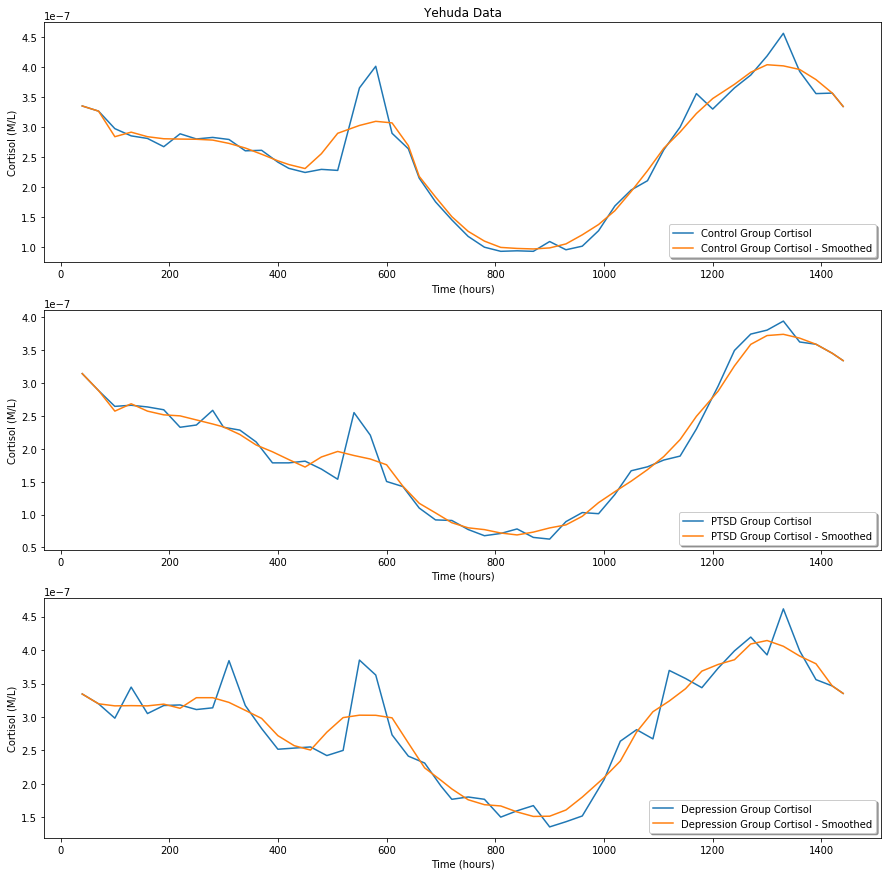

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(yehudaControlCortisol[:,0], yehudaControlCortisol[:,1], label = "Control Group Cortisol")
ax1.plot(yehudaControlCortisol_smooth[:,0], yehudaControlCortisol_smooth[:,1], label = "Control Group Cortisol - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (M/L)", title = "Yehuda Data")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(yehudaPTSDCortisol[:,0], yehudaPTSDCortisol[:,1], label = "PTSD Group Cortisol")
ax2.plot(yehudaPTSDCortisol_smooth[:,0], yehudaPTSDCortisol_smooth[:,1], label = "PTSD Group Cortisol - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (M/L)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(yehudaDepressedCortisol[:,0], yehudaDepressedCortisol[:,1], label = "Depression Group Cortisol")
ax3.plot(yehudaDepressedCortisol_smooth[:,0], yehudaDepressedCortisol_smooth[:,1], label = "Depression Group Cortisol - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (M/L)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)


In [41]:
# change the time values of the rearranged sets so that 0 minutes is now 10AM
for i in range(len(carrollControlCortisol)):
    carrollControlCortisol_rearr[i,0] = carrollControlCortisol[i,0]
    carrollControlACTH_rearr[i,0] = carrollControlACTH[i,0]
    carrollHCDepressedCortisol_rearr[i,0] = carrollHCDepressedCortisol[i,0]
    carrollHCDepressedACTH_rearr[i,0] = carrollHCDepressedACTH[i,0]
    carrollLCDepressedCortisol_rearr[i,0] = carrollLCDepressedCortisol[i,0]
    carrollLCDepressedACTH_rearr[i,0] = carrollLCDepressedACTH[i,0]
    
    carrollControlCortisol_rearr_smooth[i,0] = carrollControlCortisol[i,0]
    carrollControlACTH_rearr_smooth[i,0] = carrollControlACTH[i,0]
    carrollHCDepressedCortisol_rearr_smooth[i,0] = carrollHCDepressedCortisol[i,0]
    carrollHCDepressedACTH_rearr_smooth[i,0] = carrollHCDepressedACTH[i,0]
    carrollLCDepressedCortisol_rearr_smooth[i,0] = carrollLCDepressedCortisol[i,0]
    carrollLCDepressedACTH_rearr_smooth[i,0] = carrollLCDepressedACTH[i,0]

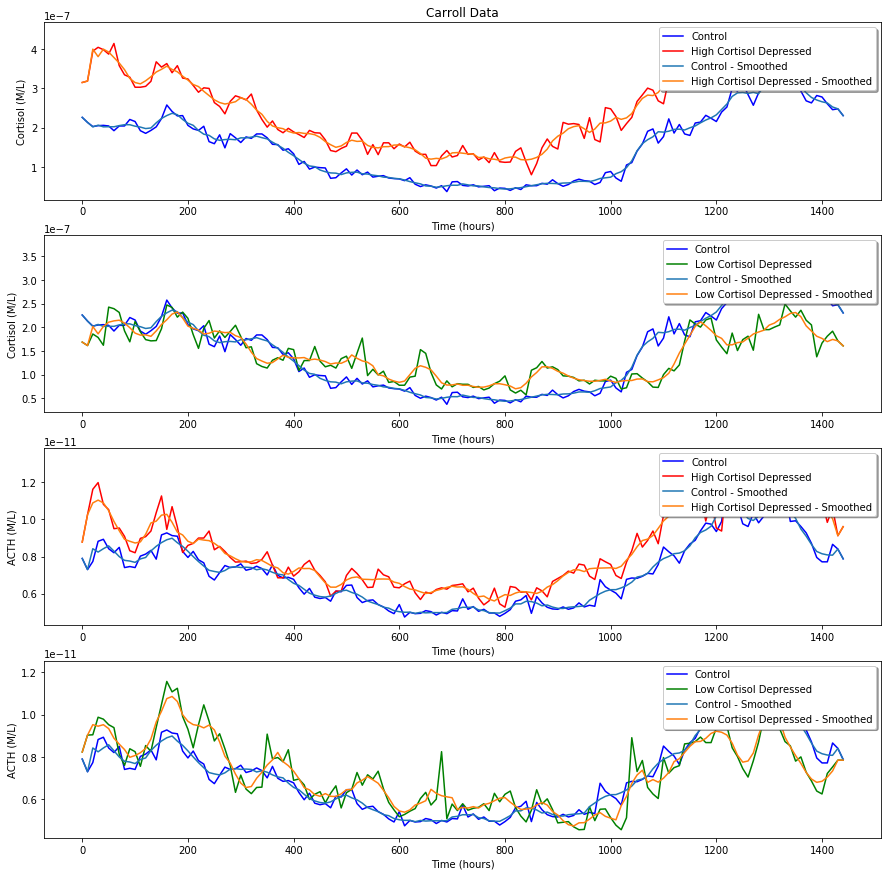

In [51]:
#mpld3.enable_notebook()
%matplotlib inline

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (15,15))

ax1.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax1.plot(carrollHCDepressedCortisol_rearr[:,0], carrollHCDepressedCortisol_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax1.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax1.plot(carrollHCDepressedCortisol_rearr_smooth[:,0], carrollHCDepressedCortisol_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (M/L)", title = "Carroll Data")
ax1.legend(loc="upper right", shadow = True, fancybox = True)

ax2.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax2.plot(carrollLCDepressedCortisol_rearr[:,0], carrollLCDepressedCortisol_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax2.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax2.plot(carrollLCDepressedCortisol_rearr_smooth[:,0], carrollLCDepressedCortisol_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (M/L)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)

ax3.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax3.plot(carrollHCDepressedACTH_rearr[:,0], carrollHCDepressedACTH_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax3.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax3.plot(carrollHCDepressedACTH_rearr_smooth[:,0], carrollHCDepressedACTH_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="ACTH (M/L)")
ax3.legend(loc="upper right", shadow = True, fancybox = True)

ax4.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax4.plot(carrollLCDepressedACTH_rearr[:,0], carrollLCDepressedACTH_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax4.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax4.plot(carrollLCDepressedACTH_rearr_smooth[:,0], carrollLCDepressedACTH_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (M/L)")
ax4.legend(loc="upper right", shadow = True, fancybox = True)

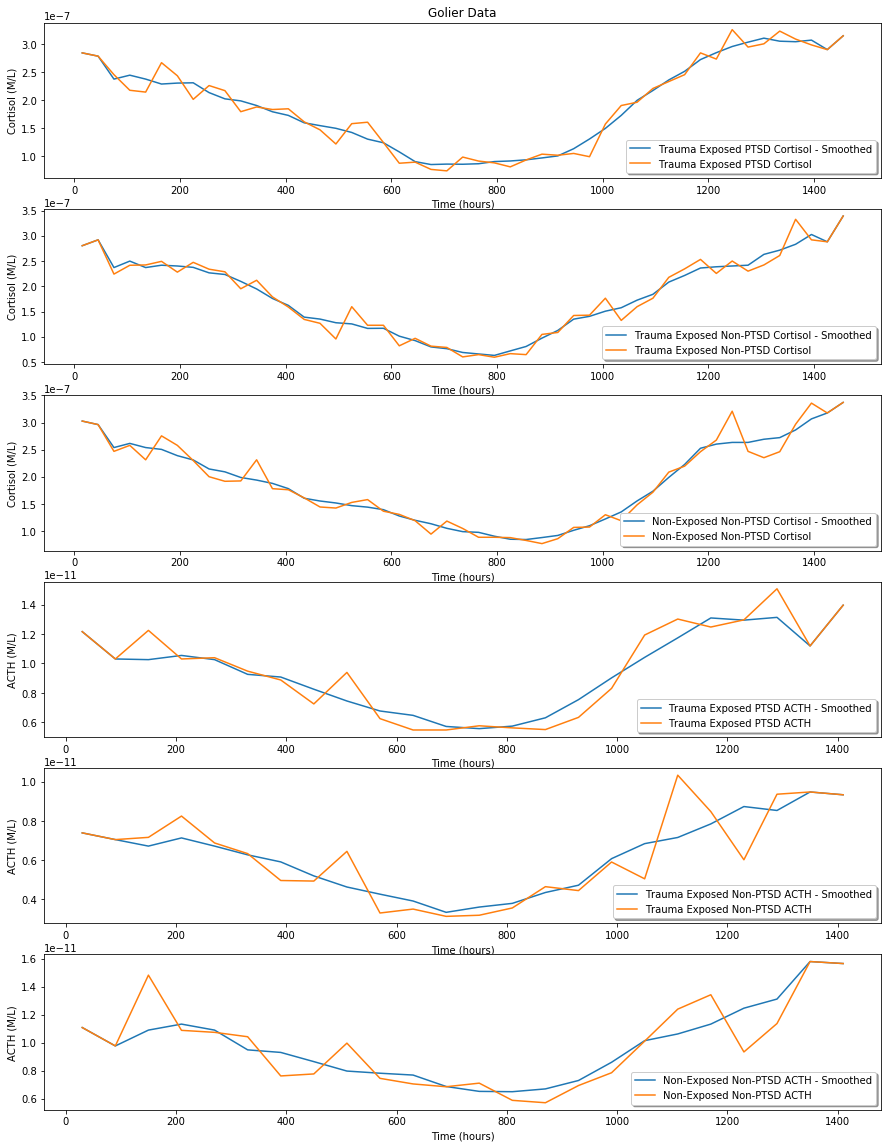

In [52]:
%matplotlib inline

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (15,20))

ax1.plot(golierPTSDCortisol_rearr_smooth[:,0], golierPTSDCortisol_rearr_smooth[:,1], label = "Trauma Exposed PTSD Cortisol - Smoothed")
ax1.plot(golierPTSDCortisol_rearr[:,0], golierPTSDCortisol_rearr[:,1], label = "Trauma Exposed PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (M/L)", title = "Golier Data")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,0], golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD Cortisol - Smoothed")
ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr[:,0], golierNonPTSDTraumaExposedCortisol_rearr[:,1], label = "Trauma Exposed Non-PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (M/L)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(golierNonPTSDNonExposedCortisol_rearr_smooth[:,0], golierNonPTSDNonExposedCortisol_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD Cortisol - Smoothed")
ax3.plot(golierNonPTSDNonExposedCortisol_rearr[:,0], golierNonPTSDNonExposedCortisol_rearr[:,1], label = "Non-Exposed Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (M/L)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)

ax4.plot(golierPTSDACTH_rearr_smooth[:,0], golierPTSDACTH_rearr_smooth[:,1], label = "Trauma Exposed PTSD ACTH - Smoothed")
ax4.plot(golierPTSDACTH_rearr[:,0], golierPTSDACTH_rearr[:,1], label = "Trauma Exposed PTSD ACTH")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (M/L)")
ax4.legend(loc="lower right", shadow = True, fancybox = True)

ax5.plot(golierNonPTSDTraumaExposedACTH_rearr_smooth[:,0], golierNonPTSDTraumaExposedACTH_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD ACTH - Smoothed")
ax5.plot(golierNonPTSDTraumaExposedACTH_rearr[:,0], golierNonPTSDTraumaExposedACTH_rearr[:,1], label = "Trauma Exposed Non-PTSD ACTH")
ax5.set(xlabel="Time (hours)", ylabel="ACTH (M/L)")
ax5.legend(loc="lower right", shadow = True, fancybox = True)

ax6.plot(golierNonPTSDNonExposedACTH_rearr_smooth[:,0], golierNonPTSDNonExposedACTH_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD ACTH - Smoothed")
ax6.plot(golierNonPTSDNonExposedACTH_rearr[:,0], golierNonPTSDNonExposedACTH_rearr[:,1], label = "Non-Exposed Non-PTSD ACTH")
ax6.set(xlabel="Time (hours)", ylabel="ACTH (M/L)")
ax6.legend(loc="lower right", shadow = True, fancybox = True)


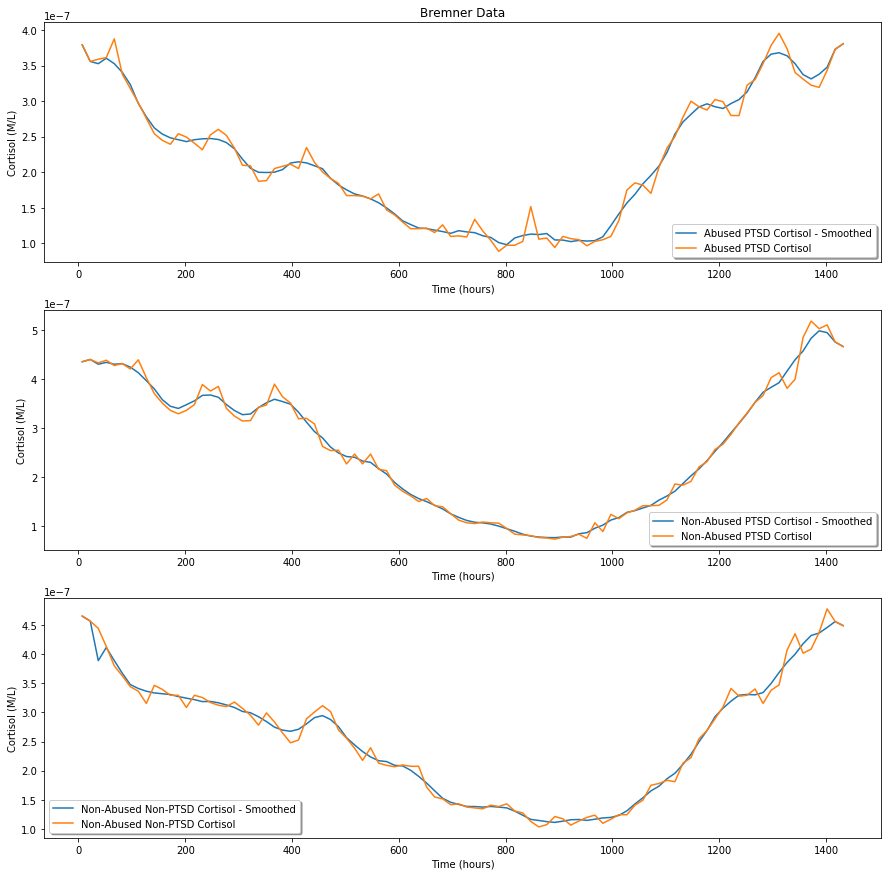

In [53]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(bremnerAbusedPTSDCortisol_rearr_smooth[:,0], bremnerAbusedPTSDCortisol_rearr_smooth[:,1], label = "Abused PTSD Cortisol - Smoothed")
ax1.plot(bremnerAbusedPTSDCortisol_rearr[:,0], bremnerAbusedPTSDCortisol_rearr[:,1], label = "Abused PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (M/L)", title = "Bremner Data")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(bremnerNonAbusedPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused PTSD Cortisol - Smoothed")
ax2.plot(bremnerNonAbusedPTSDCortisol_rearr[:,0], bremnerNonAbusedPTSDCortisol_rearr[:,1], label = "Non-Abused PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (M/L)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused Non-PTSD Cortisol - Smoothed")
ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr[:,0], bremnerNonAbusedNonPTSDCortisol_rearr[:,1], label = "Non-Abused Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (M/L)")
ax3.legend(loc="lower left", shadow = True, fancybox = True)


## Import and Arrange Nelson Data

In [65]:
# data from Dr Erik Nelson
nelsonACTH_data = np.genfromtxt("tsst_acth_nelson.txt")
nelsonCortisol_data = np.genfromtxt("tsst_cort_nelson.txt")

In [66]:
# arrange and graph the Nelson data
nelsonACTH_mean = np.zeros(11)
nelsonCortisol_mean = np.zeros(11)
nelsonACTH = np.zeros((11,60))
nelsonCortisol = np.zeros((11,60))


for i in range(len(nelsonACTH_data[1,:])-1):
    nelsonACTH_mean[i] = np.mean(nelsonACTH_data[:,i+1])
    nelsonCortisol_mean[i] = np.mean(nelsonCortisol_data[:,i+1])

t_nelson = np.array([0, 15, 30, 40, 50, 65, 80, 95, 110, 125, 140])

for i in range(len(t_nelson)):
    nelsonACTH[i,0] = t_nelson[i]
    nelsonACTH[i,1] = nelsonACTH_mean[i]
    
    nelsonCortisol[i,0] = t_nelson[i]
    nelsonCortisol[i,1] = nelsonCortisol_mean[i]
    
for i in range(len(nelsonACTH_data)):
    for j in range(len(t_nelson)):
        nelsonACTH[j,i+2] = nelsonACTH_data[i,j+1]
        nelsonCortisol[j,i+2] = nelsonCortisol_data[i,j+1]
    
for i in range(len(nelsonACTH[:,0])):
    for j in range(len(nelsonACTH[i,:])-1):
        nelsonACTH[i,j+1] = nelsonACTH[i,j+1]/2.933444e12
    
for i in range(len(nelsonCortisol[:,0])):
    for j in range(len(nelsonCortisol[i,:])-1):
        nelsonCortisol[i,j+1] = nelsonCortisol[i,j+1]/3.6246e7



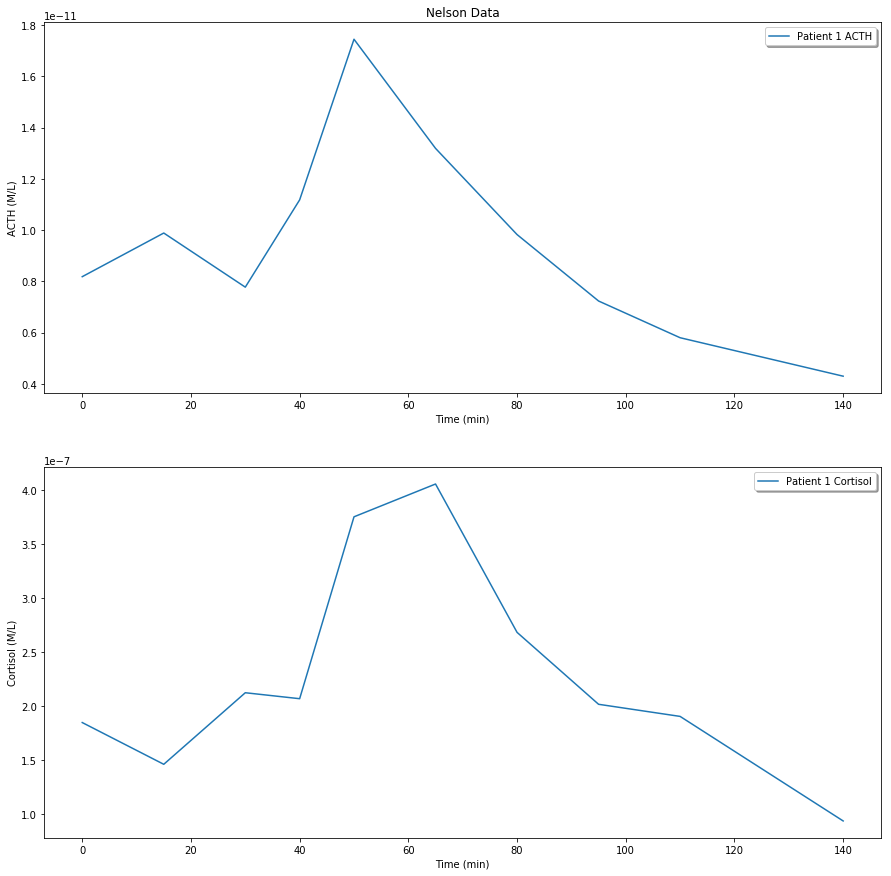

In [67]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 15))

ax1.plot(nelsonACTH[:,0], nelsonACTH[:,3], label = "Patient 1 ACTH")
ax1.set(ylabel = "ACTH (M/L)", xlabel = "Time (min)", title = "Nelson Data")
ax1.legend(loc="upper right", shadow = True, fancybox = True)

ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,3], label = "Patient 1 Cortisol")
ax2.set(ylabel = "Cortisol (M/L)", xlabel = "Time (min)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)

## Model Function -- Includes ODE Solver

In [197]:
def model(params, ics, t):
    # function for circadian input from SCN on CRH production
    def D(t, d1, d2):
        return d1 - 0.079145093*d2 + (0.064*np.sin(2*np.pi*t/1440) + 0.12*np.abs(np.sin(np.pi*t/1440)))*d2
    
    # function containing the system, to be called by solver
    def ode_system(t, y):
        # initialize array to hold ODE function values
        dy = np.zeros(19)
        
        # 2, 4, 5, 7, 12, 17, 18, 19, 20, 21, 26, 27, 30
        # , k4, k5, k7, k12, k17, k18, k19, k20, k21, k26, k27, k30

        # define parameter values
        #[d1, d2, k2] = params
        [d1, d2, k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16, k17, k18, k19, k20, k21, k22, k23, k24, k25, k26, k27, k28, k29, k30, k31, k32, k33] = params
        
        # the ODE system itself
        dy[0] = k5*y[5] - (k7*y[11] + k20*y[3] + k21)*y[0]
        dy[1] = k3 + k15*y[16] - k18*y[1]*y[3]**2 - k22*y[1]
        dy[2] = k1 - k8*y[12]*y[2] - k25*y[2] - k32*y[2]*y[18]
        dy[3] = k12*y[15] + k17*y[15]*y[3]**2 - k18*y[1]*y[3]**2 - k19*y[4]*y[3] - k20*y[0]*y[3] - k26*y[3]
        dy[4] = k2*D(t, d1, d2) - (k4 + k19*y[3] + k27)*y[4] + k30*y[17]
        dy[5] = k4*y[4] - k5*y[5]
        dy[6] = k6*y[7] - k23*y[6]
        dy[7] = k5*y[5] - k6*y[7]
        dy[8] = k6*y[7] - k24*y[8]
        dy[9] = k8*y[12]*y[2] - (k9 + k13 + k28)*y[9] + k32*y[2]*y[18]
        dy[10] = k9*y[9] - (k10 + k11)*y[10]
        dy[11] = k8*y[2]*y[12] - k7*y[0]*y[11]
        dy[12] = k7*y[0]*y[11] - k8*y[2]*y[12]
        dy[13] = k13*y[9] - (k14 + k16)*y[13]
        dy[14] = k11*y[10] - k29*y[14]
        dy[15] = k10*y[10] - (k12 + k17*y[3]**2)*y[15] + k16*y[13]
        dy[16] = k14*y[13] - k15*y[16]
        dy[17] = -k30*y[17] - k31*y[17]
        dy[18] = k31*y[17] - k32*y[2]*y[18] - k33*y[18]
        
        return dy
    
    # solve the system with scipy.integrate.ode to see if it's any faster
    solver = sci.ode(ode_system)
    solver.set_integrator('lsoda')
    solver.set_initial_value(ics, t_start)
    
    ts = []
    ys = []
    
    while solver.successful() and solver.t < t_end:
        solver.integrate(solver.t + t_step)
        ts.append(solver.t)
        ys.append(solver.y)

    # solve the system with solve_ivp
    #timeSeries = sci.solve_ivp(ode_system, t, ics, t_eval=np.arange(0,1441,0.01), method='BDF')
    
    # reshape the output frome ode to an array with the times on the first column
    ts = np.reshape(ts, (len(ts),1))
    ys = np.vstack(ys)
    timeSeries = np.hstack((ts, ys))
    return timeSeries

## Cost Function Definition

In [134]:
def cost_fun(params):
    # call the solve function
    simData = model(params, y0, timeLength)
    
    # this is where Rick makes sure we only have unique values for t, so no time step is repeated
    # I'll include it commented out here, and see if it changes anything later
    #idx = np.unique(simData[:,0], return_index = True)
    #idx = idx[1]
    #simData2 = simData[idx,:]
    #print((simData==simData2).all())
    # I tested whether using numpy.unique was necessary with this code, and it is not
    
    # here, rick performs a cubic interpolation between time steps
    # I could either do this, or just compute the SSE between the raw data and computed data points without doing
    # the interpolation.
    spline_ACTH = interp1d(simData[:,0], simData[:,2], kind = 'linear')
    spline_CORT = interp1d(simData[:,0], simData[:,3], kind = 'linear')
    
    try:
        # compute the actual cost value for the current parameter set by finding SSE between raw data and splines
        # this is where we change the data set we are trying to match, so that it computes the cost based on whatever
        #     data set we put in as the x values into the spline and the y values to subtract
        acthSSE = np.sum((spline_ACTH(carrollControlCortisol[:,0]+1440) - carrollControlCortisol[:,1])**2)
        cortSSE = np.sum((spline_CORT(carrollControlACTH[:,0]+1440) - carrollControlACTH[:,1])**2)

        # if i run it with acth data, also, can make cost the average of cortisol and ACTH SSEs
        cost = (acthSSE+cortSSE)/2
        # for now though, cost is just the SSE of cortisol data and simulation
        #cost = cortSSE

        return cost
    except ValueError:
        print("ODE solver did not make it through all data points.")

## Run the Optimization

In [191]:
# number of times to run the optimization
n = 5

# define an array to hold the population of parameter vectors
opt_pars = np.zeros((n, len(bounds)+1))

# initialize arrays to save simulation cortisol and ACTH data from each optimization
sims_acth = np.zeros((288201, n))
sims_aldo = np.zeros((288201, n))
sims_chol = np.zeros((288201, n))
sims_cort = np.zeros((288201, n))
sims_crh = np.zeros((288201, n))
sims_pomc = np.zeros((288201, n))
sims_bend = np.zeros((288201, n))
sims_blph = np.zeros((288201, n))
sims_bmsh = np.zeros((288201, n))
sims_pnn = np.zeros((288201, n))
sims_hpnn = np.zeros((288201, n))
sims_mc2 = np.zeros((288201, n))
sims_mc2a = np.zeros((288201, n))
sims_pgs = np.zeros((288201, n))
sims_tts = np.zeros((288201, n))
sims_hpgs = np.zeros((288201, n))
sims_cts = np.zeros((288201, n))
sims_etoh = np.zeros((288201, n))
sims_acald = np.zeros((288201, n))

In [196]:
%%time

# loop n times, running the optimization each time
for i in range(0,n):
    
    print(f"Optimization Run #{i+1}")
    
    # call the differential evolution optimization function on the cost function
    res = sco.differential_evolution(cost_fun, bounds, maxiter = 999, disp = True, popsize = 5)
    
    # alternatively, we can run the SHGO algorithm with the sampling_method = "sobol" flag to do global
    #     optimization with reporting all local minima, as well
    #res = sco.shgo(cost_fun, bounds, callback=callback_fun(*shgo_iter_steps), options = {"f_min": 0.1, "maxiter": None, "minimize_every_iter": True, "local_iter": False, "disp": True}, iters = 3)
    #res = sco.basinhopping(cost_fun, x0, niter = 1000)
    #res = sco.dual_annealing(cost_fun, bounds)
    
    # plug the optimized parameters into the solver
    optimizedSimData = model(res.x, y0, timeLength)
    print(optimizedSimData.shape)
    
    # save CRH, cortisol and ACTH data into sims arrays
    sims_acth = optimizedSimData[:,1]
    sims_aldo = optimizedSimData[:,2]
    sims_chol = optimizedSimData[:,3]
    sims_cort = optimizedSimData[:,4]
    sims_crh = optimizedSimData[:,5]
    sims_pomc = optimizedSimData[:,6]
    sims_bend = optimizedSimData[:,7]
    sims_blph = optimizedSimData[:,8]
    sims_bmsh = optimizedSimData[:,9]
    sims_pnn = optimizedSimData[:,10]
    sims_hpnn = optimizedSimData[:,11]
    sims_mc2 = optimizedSimData[:,12]
    sims_mc2a = optimizedSimData[:,13]
    sims_pgs = optimizedSimData[:,14]
    sims_tts = optimizedSimData[:,15]
    sims_hpgs = optimizedSimData[:,16]
    sims_cts = optimizedSimData[:,17]
    sims_etoh = optimizedSimData[:,18]
    sims_acald = optimizedSimData[:,19]
    
    # save the cost function values and optimized parameters for each iteration into the array opt_pars
    opt_pars[i,0] = res.fun
    opt_pars[i,1:] = res.x

Optimization Run #1
differential_evolution step 1: f(x)= 0.000655692
(288201, 20)
Optimization Run #2
differential_evolution step 1: f(x)= 0.000655692
(288201, 20)
Optimization Run #3
differential_evolution step 1: f(x)= 0.000655692
(288201, 20)
Optimization Run #4
ODE solver did not make it through all data points.


TypeError: '>' not supported between instances of 'float' and 'NoneType'

In [170]:
print(sims_cort)

[3.99489171e-08 3.98994961e-08 3.98508989e-08 ... 2.85414154e-06
 2.85414055e-06 2.85413955e-06]


## Report the Means +- Standard Deviation for Each Parameter

In [209]:
a_0_mean = np.mean(opt_pars[:,1])
a_1_mean = np.mean(opt_pars[:,2])
a_5_mean = np.mean(opt_pars[:,3])
w_1_mean = np.mean(opt_pars[:,4])
w_2_mean = np.mean(opt_pars[:,5])
w_3_mean = np.mean(opt_pars[:,6])
delta_mean = np.mean(opt_pars[:,7])

In [210]:
a_0_std = np.std(opt_pars[:,1])
a_1_std = np.std(opt_pars[:,2])
a_5_std = np.std(opt_pars[:,3])
w_1_std = np.std(opt_pars[:,4])
w_2_std = np.std(opt_pars[:,5])
w_3_std = np.std(opt_pars[:,6])
delta_std = np.std(opt_pars[:,7])
param_stds = (a_0_std, a_1_std, a_5_std, w_1_std, w_2_std, w_3_std, delta_std)

In [211]:
print(tabulate([["a_0", "%f +- %f" % (a_0_mean, a_0_std)], ["a_1", "%f +- %f" % (a_1_mean, a_1_std)], ["a_5", "%f +- %f" % (a_5_mean, a_5_std)], ["w_1", "%f +- %f" % (w_1_mean, w_1_std)], ["w_2", "%f +- %f" % (w_2_mean, w_2_std)], ["w_3", "%f +- %f" % (w_3_mean, w_3_std)], ["delta", "%f +- %f" % (delta_mean, delta_std)]], headers = ["Parameter", "Mean +- Standard Deviation"]))


Parameter    Mean +- Standard Deviation
-----------  --------------------------------
a_0          0.003387 +- 0.000000
a_1          6706232313072.934570 +- 0.000000
a_5          0.023198 +- 0.000000
w_1          0.001350 +- 0.000000
w_2          0.106039 +- 0.000000
w_3          0.037860 +- 0.000000
delta        2858.193015 +- 0.000000


## Save Results to Files

In [83]:
np.savetxt('stanojevic-carrollControl-opt-pars-1-iteration-expanded-bounds.txt', opt_pars)

In [84]:
np.savetxt('stanojevic-carrollControl-sims-crh-1-iteration-expanded-bounds.txt', sims_crh)
np.savetxt('stanojevic-carrollControl-sims-acth-1-iteration-expanded-bounds.txt', sims_acth)
np.savetxt('stanojevic-carrollControl-sims-cort-1-iteration-expanded-bounds.txt', sims_cort)

In [85]:
np.savetxt('stanojevic-carrollControl-initial-conditions-1-iteration-expanded-bounds.txt', y0)
np.savetxt('stanojevic-carrollControl-bounds-1-iteration-expanded-bounds.txt', bounds)

In [86]:
np.savetxt('stanojevic-carrollControl-param-means-stds-1-iteration-expanded-bounds.txt', [a_0_mean, a_0_std, a_1_mean, a_1_std, a_5_mean, a_5_std, w_1_mean, w_1_std, w_2_mean, w_2_std, w_3_mean, w_3_std, delta_mean, delta_std])

## Graph the Obtained Data

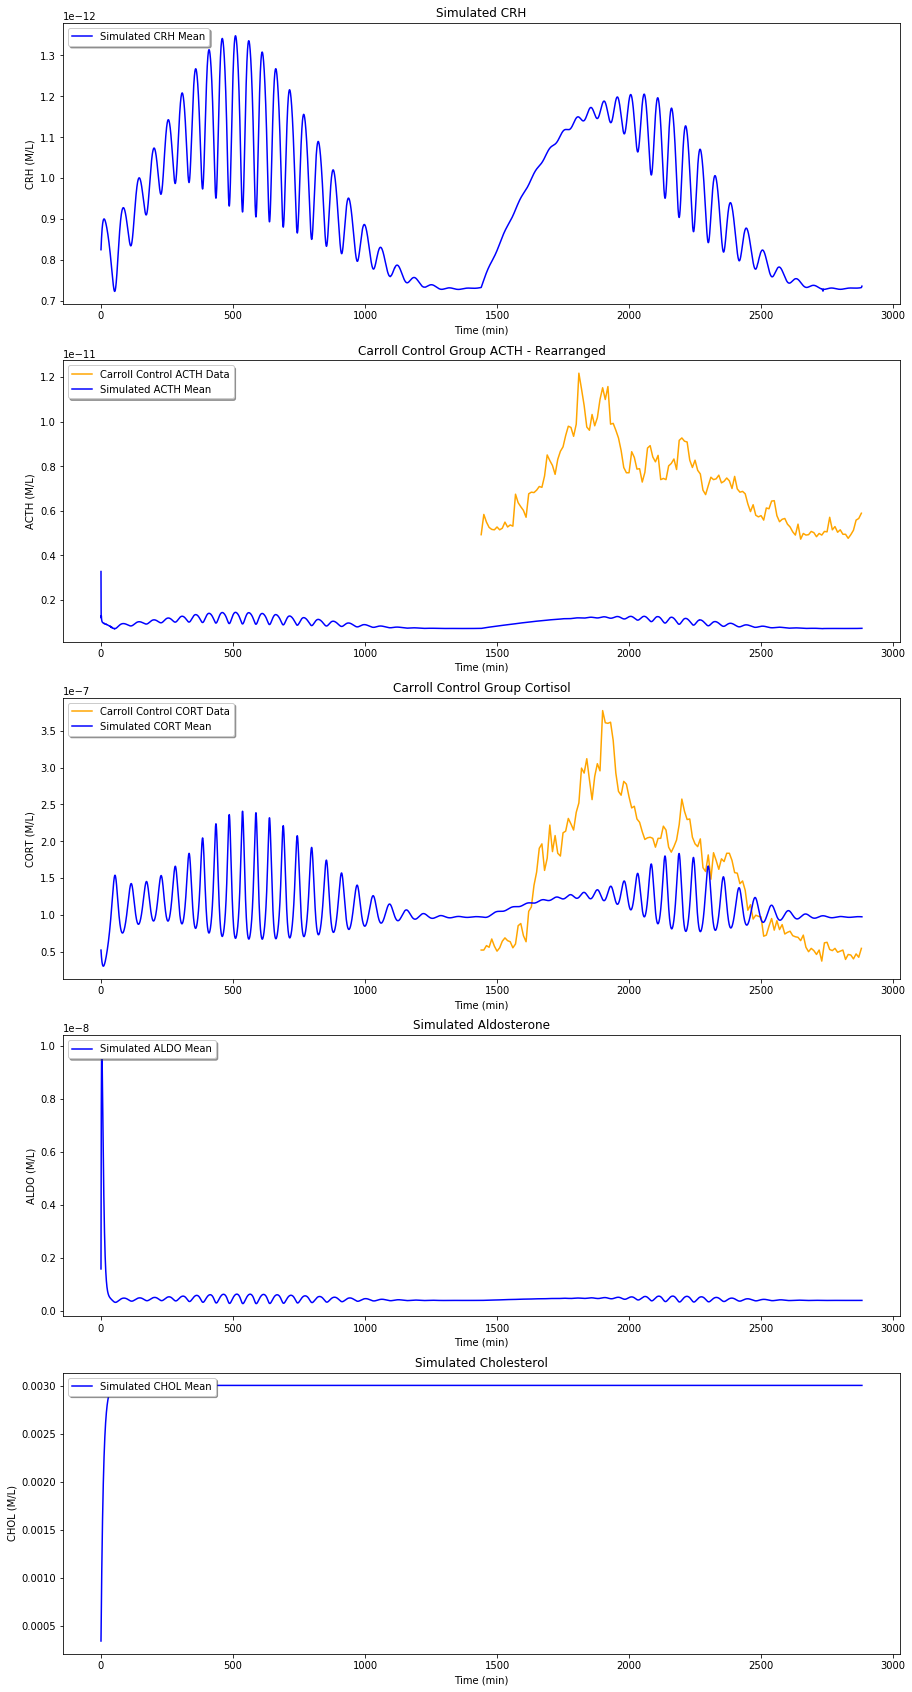

In [187]:
# graphing code for Nelson data

%matplotlib inline
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 5, figsize = (15, 30))

ax1.plot(optimizedSimData[:,0], np.mean(sims_crh, axis = 1), label = "Simulated CRH Mean", color = "blue")
ax1.fill_between(optimizedSimData[:,0], np.mean(sims_crh, axis = 1) - np.std(sims_crh, axis = 1), np.mean(sims_crh, axis = 1) + np.std(sims_crh, axis = 1), alpha = 0.3, label = "Simulated CRH Standard Deviation")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (min)", ylabel = "CRH (M/L)", title = "Simulated CRH")

ax2.plot(carrollControlACTH[:,0]+1440, carrollControlACTH[:,1], label = "Carroll Control ACTH Data", color = "orange")
ax2.plot(optimizedSimData[:,0], np.mean(sims_acth, axis = 1), label = "Simulated ACTH Mean", color = "blue")
ax2.fill_between(optimizedSimData[:,0], np.mean(sims_acth, axis = 1) - np.std(sims_acth, axis = 1), np.mean(sims_acth, axis = 1) + np.std(sims_acth, axis = 1), alpha = 0.3, label = "Simulated ACTH Standard Deviation")
ax2.legend(loc = "upper left", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (min)", ylabel = "ACTH (M/L)", title = "Carroll Control Group ACTH - Rearranged")

ax3.plot(carrollControlCortisol[:,0]+1440, carrollControlCortisol[:,1], label = "Carroll Control CORT Data", color = "orange")
ax3.plot(optimizedSimData[:,0], np.mean(sims_cort, axis = 1), label = "Simulated CORT Mean", color = "blue")
ax3.fill_between(optimizedSimData[:,0], np.mean(sims_cort, axis = 1) - np.std(sims_cort, axis = 1), np.mean(sims_cort, axis = 1) + np.std(sims_cort, axis = 1), alpha = 0.3, label = "Simulated Cortisol Standard Deviation")
ax3.legend(loc = "upper left", shadow = True, fancybox = True)
ax3.set(xlabel = "Time (min)", ylabel = "CORT (M/L)", title = "Carroll Control Group Cortisol")

ax4.plot(optimizedSimData[:,0], np.mean(sims_aldo, axis = 1), label = "Simulated ALDO Mean", color = "blue")
ax4.fill_between(optimizedSimData[:,0], np.mean(sims_aldo, axis = 1) - np.std(sims_aldo, axis = 1), np.mean(sims_aldo, axis = 1) + np.std(sims_aldo, axis = 1), alpha = 0.3, label = "Simulated ALDO Standard Deviation")
ax4.legend(loc = "upper left", shadow = True, fancybox = True)
ax4.set(xlabel = "Time (min)", ylabel = "ALDO (M/L)", title = "Simulated Aldosterone")

ax5.plot(optimizedSimData[:,0], np.mean(sims_chol, axis = 1), label = "Simulated CHOL Mean", color = "blue")
ax5.fill_between(optimizedSimData[:,0], np.mean(sims_chol, axis = 1) - np.std(sims_chol, axis = 1), np.mean(sims_chol, axis = 1) + np.std(sims_chol, axis = 1), alpha = 0.3, label = "Simulated CHOL Standard Deviation")
ax5.legend(loc = "upper left", shadow = True, fancybox = True)
ax5.set(xlabel = "Time (min)", ylabel = "CHOL (M/L)", title = "Simulated Cholesterol")

plt.savefig("../Images/Stanojevic Model Figures/stanojevic-carrollControl-10-iterations-5percent-bounds-d1d2k2.png", dpi = 300)

## Run Model w/o Optimization

In [49]:
print(x0)

[0.3025, 1.0, 0.000331, 8.78e-08, 1.46e-10, 22000.0, 240, 240, 7.61e+18, 19000000000.0, 15.47, 7.7, 0.037, 0.023, 0.25, 0.25, 0.24, 0.0001, 3020000000000.0, 16900000000000.0, 72000000000.0, 600000000.0, 1280.0, 0.81, 2400.0, 24000.0, 0.11, 0.098, 0.0013, 0.026, 12, 0.001, 2.5e-07, 0.005, 0.1]


In [201]:
y0 = [4.934435428117939e-12, 1.5e-9, 3.4e-4, 5.2511256414500915e-8, 1e-12, 1.5e-10, 1.5e-11, 1.5e-10, 1.5e-11, 1.0e-10, 4.0e-8, 1.5e-15, 1.5e-15, 4.0e-8, 4.0e-8, 4.0e-8, 4.0e-8, 0, 0]
x0 = [d1, d2, k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16, k17, k18, k19, k20, k21, k22, k23, k24, k25, k26, k27, k28, k29, k30, k31, k32, k33]

res = model(x0, y0, timeLength)

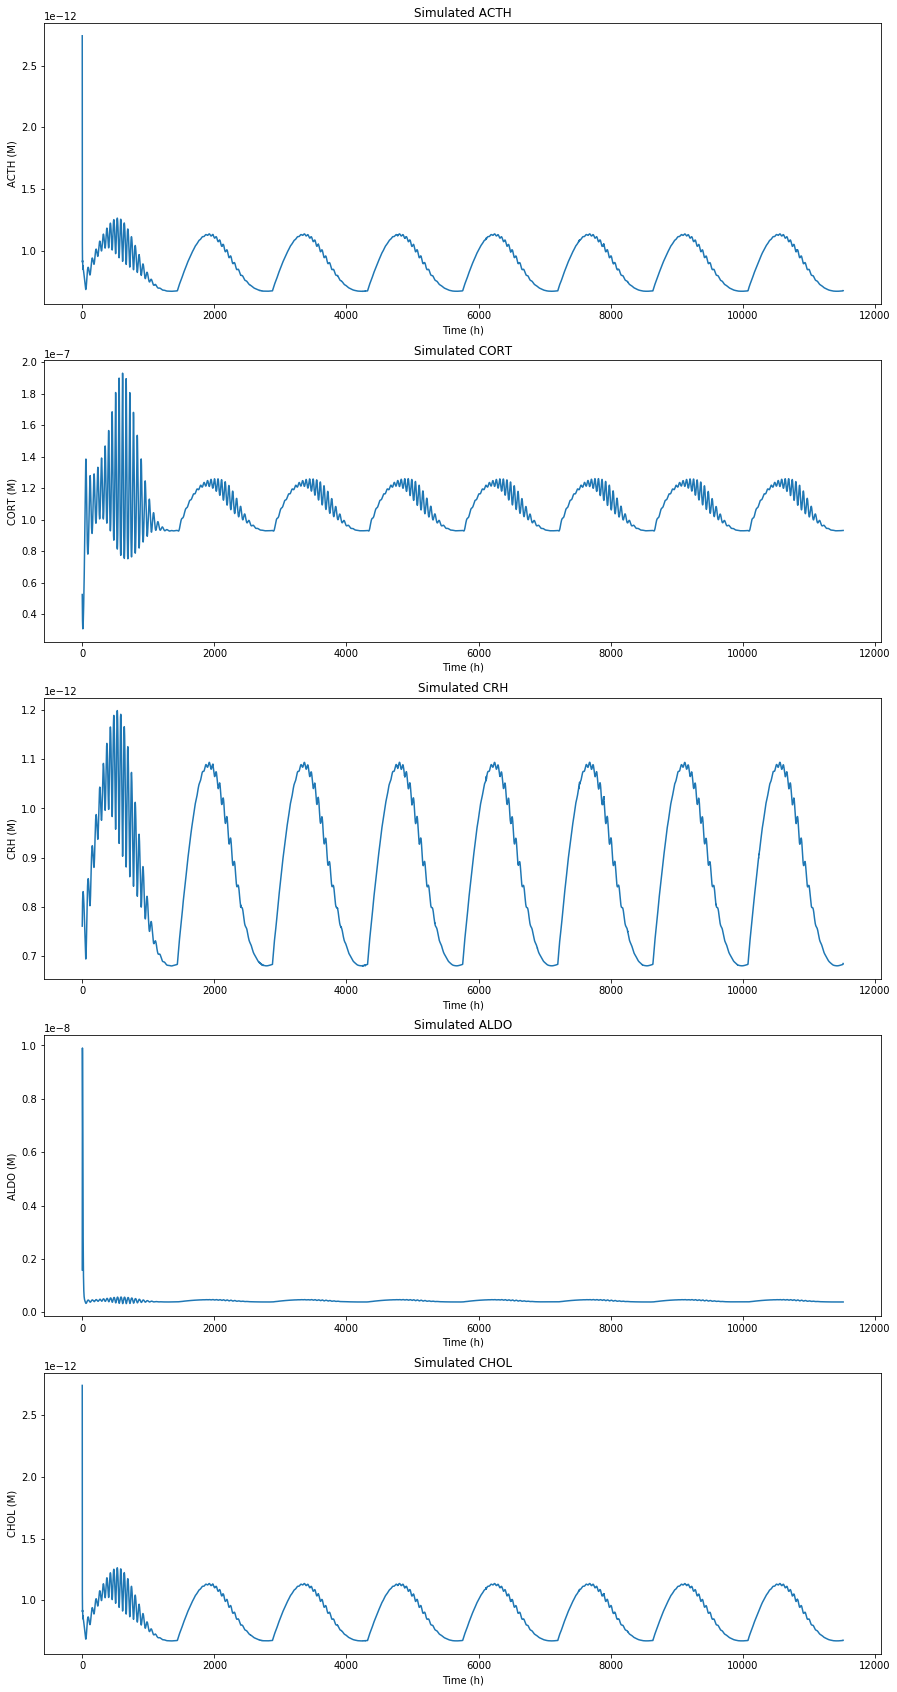

In [202]:
%matplotlib inline

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 5, figsize = (15,30))

ax1.plot(res[:,0], res[:,1], label = "Simulated ACTH")
#ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "ACTH (M)", title = "Simulated ACTH")

ax2.plot(res[:,0], res[:,4], label = "Simulated Cortisol")
#ax2.legend(loc = "upper left", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "CORT (M)", title = "Simulated CORT")

ax3.plot(res[:,0], res[:,5], label = "Simulated CRH")
#ax3.legend(loc = "upper left", shadow = True, fancybox = True)
ax3.set(xlabel = "Time (h)", ylabel = "CRH (M)", title = "Simulated CRH")

ax4.plot(res[:,0], res[:,2], label = "Simulated Aldosterone")
#ax4.legend(loc = "upper left", shadow = True, fancybox = True)
ax4.set(xlabel = "Time (h)", ylabel = "ALDO (M)", title = "Simulated ALDO")

ax5.plot(res[:,0], res[:,1], label = "Simulated Cholesterol")
#ax5.legend(loc = "upper left", shadow = True, fancybox = True)
ax5.set(xlabel = "Time (h)", ylabel = "CHOL (M)", title = "Simulated CHOL")

plt.savefig("stanojevic-author-params-8-days.png")